In [9]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [2]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)#拉直
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq) 
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

       Sales of shampoo over a three year period
Month                                           
1-01                                       266.0
1-02                                       145.9
1-03                                       183.1
1-04                                       119.3
1-05                                       180.3
[[342.3 339.7 440.4 315.9]
 [339.7 440.4 315.9 439.3]
 [440.4 315.9 439.3 401.3]
 [315.9 439.3 401.3 437.4]
 [439.3 401.3 437.4 575.5]
 [401.3 437.4 575.5 407.6]
 [437.4 575.5 407.6 682. ]
 [575.5 407.6 682.  475.3]
 [407.6 682.  475.3 581.3]
 [682.  475.3 581.3 646.9]]
Train: (23, 4), Test: (10, 4)


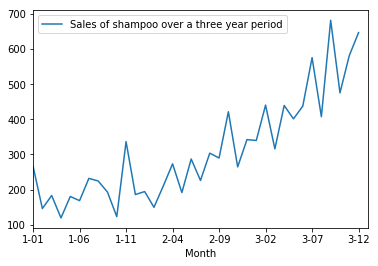

In [12]:
# load dataset
series = read_csv('/Users/houzhuo/Downloads/shampoo1.csv', header=0, index_col=0)
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
print(series.head())
train, test = prepare_data(series, n_test, n_lag, n_seq)
print(test)
print('Train: %s, Test: %s' % (train.shape, test.shape))
series.plot()
plt.show()

In [14]:
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]#取最后一个观察值，并且输出一个向量，包含seq个不变的观察值
 
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]#第i行的第一个；第i行后三列
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)#输出test行（10个）值为第三列的列表。10*3
	return forecasts
 

In [18]:
forecasts = make_forecasts(train, test, 1, 3)
forecasts


[[342.3, 342.3, 342.3],
 [339.7, 339.7, 339.7],
 [440.4, 440.4, 440.4],
 [315.9, 315.9, 315.9],
 [439.3, 439.3, 439.3],
 [401.3, 401.3, 401.3],
 [437.4, 437.4, 437.4],
 [575.5, 575.5, 575.5],
 [407.6, 407.6, 407.6],
 [682.0, 682.0, 682.0]]

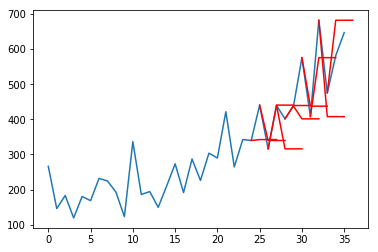

In [24]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - 12 + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()
# plot forecasts
plot_forecasts(series, forecasts, 12)

In [29]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]#每列预测值，三列的值是一样的
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq) 

t+1 RMSE: 144.535304
t+2 RMSE: 86.479905
t+3 RMSE: 121.149168


In [28]:
[forecast[0] for forecast in forecasts]

[342.3, 339.7, 440.4, 315.9, 439.3, 401.3, 437.4, 575.5, 407.6, 682.0]